In [1]:
from __future__ import division
from IPython.display import Image
import numpy as np
import cPickle as pickle
from fatiando import utils, gridder
from fatiando.gravmag import polyprism, harvester
from fatiando.mesher import PolygonalPrism, PrismMesh, vremove
from fatiando.vis import mpl, myv
import fatiando

In [2]:
fatiando.__version__

'0.3-198-g1d42e1d'

In [3]:
bounds = [1000, 9000, 1000, 9000, 0, 2500]

First, draw the polygonal prism outlines for the body and the neck. Copy and paste the code below to draw the bottle from scratch. Or just run the other cell to load the bottle model from a `pickle` file.

    prop = {'density':1000}
    corpo = [PolygonalPrism(mpl.draw_polygon(bounds[:4], mpl.gca(), xy2ne=True), z1=0, z2=1500, props=prop)]
    mpl.figure()
    for layer in corpo:
        mpl.polygon(layer, xy2ne=True)
    gargalo = [PolygonalPrism(mpl.draw_polygon(bounds[:4], mpl.gca(), xy2ne=True), z1=0, z2=1500, props=prop)]
    garrafa = corpo + gargalo
    # Pickle things for preservation
    with open('garrafa.pickle', 'w') as f:
        pickle.dump(garrafa, f)

In [4]:
with open('garrafa.pickle') as f:
    garrafa = pickle.load(f)

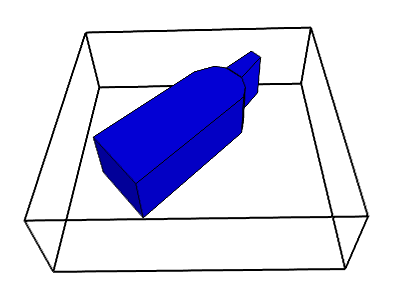

In [12]:
scene = myv.figure()
myv.polyprisms(garrafa)
myv.outline(bounds)
scene.scene.camera.position = [-4888.0010638331632, 5393.7623930350392, -8651.6194067160195]
scene.scene.camera.focal_point = [4916.1030372969672, 5045.716478034652, 1915.4158039538161]
scene.scene.camera.view_angle = 37.5
scene.scene.camera.view_up = [0.73324345607001751, 0.015891371067829285, -0.67978047813693565]
scene.scene.camera.clipping_range = [6421.9369963260087, 23548.934321230459]
scene.scene.camera.compute_view_plane_normal()
scene.scene.render()
myv.savefig('pinga-model.png')
myv.show()
Image(filename='pinga-model.png')

Now calculate a gravity gradient

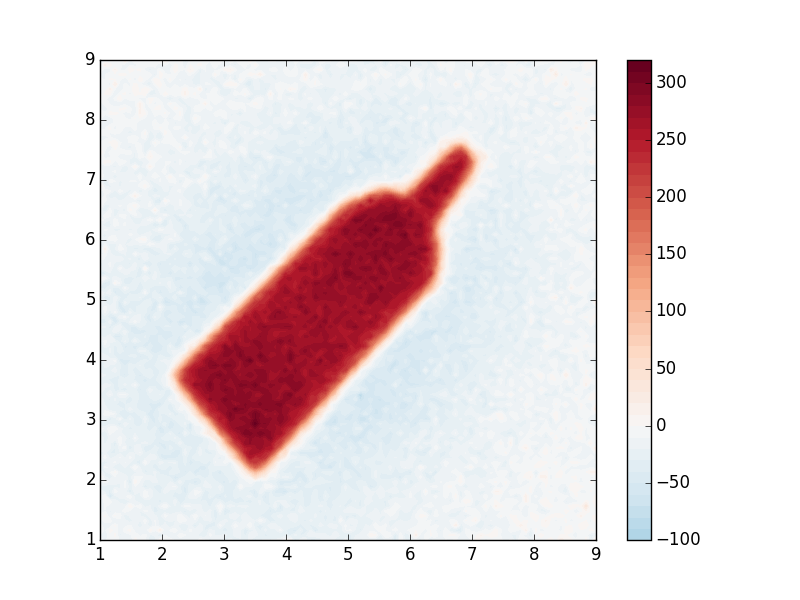

In [5]:
shape = (100, 100)
x, y, z = gridder.regular(bounds[:4], shape, z=-100)
gzz = utils.contaminate(polyprism.gzz(x, y, z, garrafa), 10)
mpl.figure()
ranges = np.abs([gzz.min(), gzz.max()]).max()
mpl.contourf(y, x, gzz, shape, 50, cmap="RdBu_r", vmin=-ranges, vmax=ranges)
mpl.colorbar()
mpl.m2km()
mpl.savefig('pinga-anomaly.png')
mpl.close()
Image(filename='pinga-anomaly.png')

To make it look nicer, use the `harvester` inversion on it

In [6]:
bounds = [1000, 9000, 1000, 9000, 0, 2500]
mesh = PrismMesh(bounds, (10, 40, 40))
seeds = harvester.sow(
    [[4000, 4000, 1000, {'density':1000}], [5000, 5000, 1000, {'density':1000}]],
    mesh)
print mesh.dims

(200.0, 200.0, 250.0)


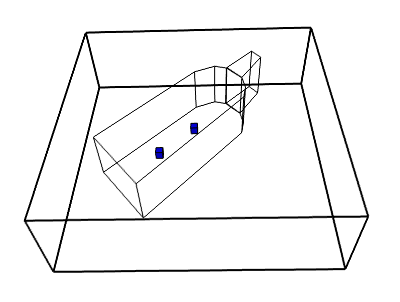

In [15]:
scene = myv.figure()
myv.polyprisms(garrafa, style='wireframe', color=(0, 0, 0))
myv.prisms(seeds)
myv.outline(bounds)
scene.scene.camera.position = [-4888.0010638331632, 5393.7623930350392, -8651.6194067160195]
scene.scene.camera.focal_point = [4916.1030372969672, 5045.716478034652, 1915.4158039538161]
scene.scene.camera.view_angle = 37.5
scene.scene.camera.view_up = [0.73324345607001751, 0.015891371067829285, -0.67978047813693565]
scene.scene.camera.clipping_range = [6421.9369963260087, 23548.934321230459]
scene.scene.camera.compute_view_plane_normal()
scene.scene.render()
myv.savefig('pinga-seed.png')
myv.show()
Image(filename='pinga-seed.png')

In [7]:
data = [harvester.Gzz(x, y, z, gzz)]
estimate, predicted = harvester.harvest(data, seeds, mesh, compactness=10, threshold=0.0005)
mesh.addprop('density', estimate['density'])
pinga = vremove(0, 'density', mesh)
print len(pinga)

1614


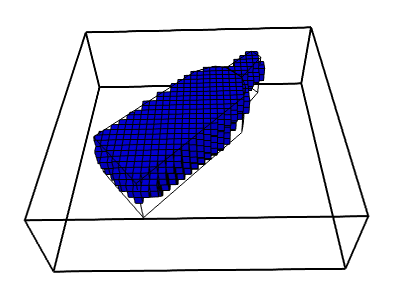

In [17]:
scene = myv.figure()
myv.polyprisms(garrafa, style='wireframe', color=(0, 0, 0))
myv.prisms(pinga)
myv.outline(bounds)
scene.scene.camera.position = [-4888.0010638331632, 5393.7623930350392, -8651.6194067160195]
scene.scene.camera.focal_point = [4916.1030372969672, 5045.716478034652, 1915.4158039538161]
scene.scene.camera.view_angle = 37.5
scene.scene.camera.view_up = [0.73324345607001751, 0.015891371067829285, -0.67978047813693565]
scene.scene.camera.clipping_range = [6421.9369963260087, 23548.934321230459]
scene.scene.camera.compute_view_plane_normal()
scene.scene.render()
myv.savefig('pinga-estimate.png')
myv.show()
Image(filename='pinga-estimate.png')

In [8]:
# Pickle things for preservation
with open('pinga.pickle', 'w') as f:
    pickle.dump(pinga, f)

In [7]:
with open('pinga.pickle') as f:
    pinga = pickle.load(f)

Now make the better plot with the data and the estimated model bellow:

In [8]:
gzzsmooth = utils.contaminate(polyprism.gzz(x, y, -200*np.ones_like(z), garrafa), 5)

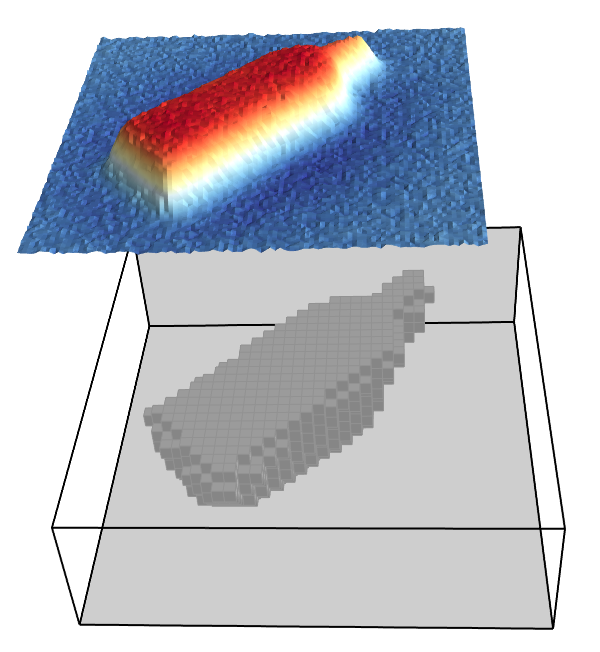

In [11]:
scene = myv.figure(size=(600, 700))
scale = 4
Z = np.reshape(gzzsmooth, shape, order='F')
X = np.reshape(x, shape, order='F')
Y = np.reshape(y, shape, order='F')
p = myv.mlab.contour_surf(X, Y, -Z, contours=100, colormap='RdYlBu')
p.contour.filled_contours = True
p.actor.actor.position = (4000, -1000, -2500)
p.actor.actor.scale = (1, 1, scale)
color = (186/255., 186/255., 186/255)
myv.prisms(pinga, edges=True, color=color, edgecolor=(146/255., 146/255., 146/255))
myv.outline(bounds)
myv.wall_north(bounds)
myv.wall_bottom(bounds)
scene.scene.camera.position = [-11517.771533450268, 6481.4701976059032, -14457.100539805206]
scene.scene.camera.focal_point = [5762.870235497453, 4683.8276618393529, -136.58381439218442]
scene.scene.camera.view_angle = 30.0
scene.scene.camera.view_up = [0.63872930678763729, 0.011218316174622961, -0.76934973973661069]
scene.scene.camera.clipping_range = [8774.155766040436, 42615.697051737574]
scene.scene.camera.compute_view_plane_normal()
scene.scene.render()
myv.savefig('pinga-logo.png')
myv.show()
Image(filename='pinga-logo.png', width=200)

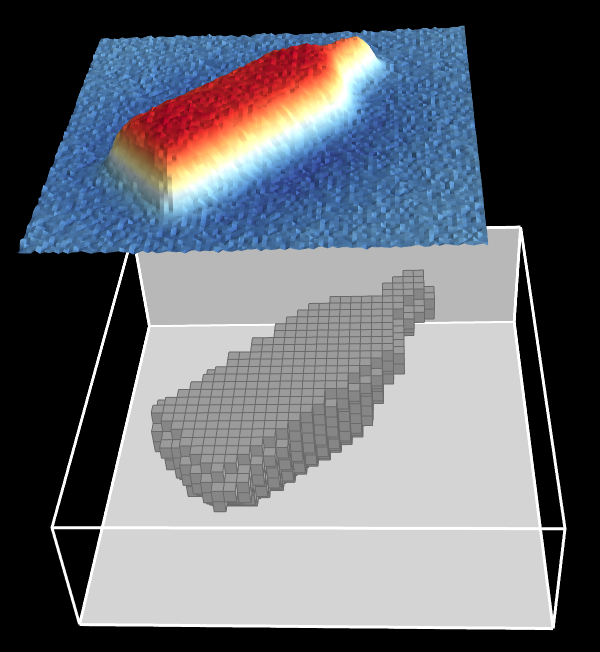

In [24]:
scene = myv.figure(size=(600, 700), color=(0, 0, 0))
scale = 4
Z = np.reshape(gzzsmooth, shape, order='F')
X = np.reshape(x, shape, order='F')
Y = np.reshape(y, shape, order='F')
p = myv.mlab.contour_surf(X, Y, -Z, contours=100, colormap='RdYlBu')
p.contour.filled_contours = True
p.actor.actor.position = (4000, -1000, -2500)
p.actor.actor.scale = (1, 1, scale)
color = (186/255., 186/255., 186/255)
myv.prisms(pinga, edges=True, color=color, edgecolor=(106/255., 106/255., 106/255))
myv.outline(bounds, color=(1, 1, 1), width=3)
myv.wall_north(bounds, opacity=1, color=(1, 1, 1))
myv.wall_bottom(bounds, opacity=1, color=(1, 1, 1))
scene.scene.camera.position = [-11517.771533450268, 6481.4701976059032, -14457.100539805206]
scene.scene.camera.focal_point = [5762.870235497453, 4683.8276618393529, -136.58381439218442]
scene.scene.camera.view_angle = 30.0
scene.scene.camera.view_up = [0.63872930678763729, 0.011218316174622961, -0.76934973973661069]
scene.scene.camera.clipping_range = [8774.155766040436, 42615.697051737574]
scene.scene.camera.compute_view_plane_normal()
scene.scene.render()
myv.savefig('pinga-logo-black.png')
myv.show()
Image(filename='pinga-logo-black.png', width=200)